# Detection of Toxic Comments

This project aims to describe the toxicity of a comment posted on an online forum.

We will break down the concept of toxicity into 6 different __categories__:<br><br>

<center>
toxicity, severe toxicity, obscanity, threat, insult and identity hate
</center>
<br><br>

To achieve this, we'll design and train a neural net on a dataset of YouTube comments retreived from a [Kaggle competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data).  
This dataset will consist of a __corpus__ of  __comments__ together with their associated __labels__ which in turn consist of 6 binary  __categories__

We'll begin by _cleaning up_ the comments:  
Since a lot of the words in each comments are irrelevant for the purposes of detecting toxicity: stopwords, hyperlinks, spelling mistakes, characters, etc.. It makes sense to remove those from the comments

Next, we'll reduce the data

First, we will analyze the distribution of comment lengths 

We will analyze the distribution of labels. it will be clear that the data is skewed in the sense that the overwhelming majority of comments exhibit no toxicity, to remedy this we will shrink the dataset


Next, we will preprocess the data

After that, we will fit both a feedforward neural net as well as an LSTM

In order to fit a neural net on the corpus, we will embed each word into a vector space using the [Glove embedding](https://nlp.stanford.edu/projects/glove/) 

## Import the necessary functionalities

In [16]:
import csv
import time
from random import sample
from datetime import datetime
import string
import pandas as pd
import numpy as np
import itertools
from scipy.sparse import csr_matrix
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from nltk.corpus import words
import tqdm
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, merge, Dot, RepeatVector, Concatenate, Input, Dropout, LSTM, GRU, Activation,GlobalMaxPool1D,Bidirectional
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
cache_english_stopwords= stopwords.words('english')

ModuleNotFoundError: No module named 'keras'

## Declare the necessary global variables:

In [10]:
# Name each category of toxicity:
categories = ['toxicity', 'severe toxicity', 'obsanity', 'threat', 'insult',  'identity hate']
num_categories = len(categories)


# Declare a custom list of words we'll replace as we clean up each comment:
replacement_list = [
    ('f u c k', 'fuck'),
    ('f uck', 'fuck'),
    ('fuckyou', 'fuck you'),
    ('fuckmother', 'fuck mother'),
    ('WTF', 'what the fuck'),
    ('OMFG', 'oh my fucking god'),
    ('RTFM', 'read the fucking manual'),
    ('ASAFP', 'as soon as fucking possible'),
    ('FYVM',  'fuck you very much'),
    ('whatever TF', 'whatever the fuck'),
    ('G AY', 'GAY'),
    

    # the following characters need to be removed by hand:
    ('•',''),
    ('·','')
    ]

# Declare the dimension of the space we will embed each word into:
dimension = 22

#Declare the scalar function according to which we'll remove outliers:
prop = len

# Declare the maximal length of each comment:
max_comment_length = 100

# Declare the percentage of zero comments we'll include in the corpus:
percentage = 0.4



## Load the dataset and the GloVe embedding:

We begin by loading the dataset. The function below takes in a set of YouTube comments and returns the:  
    1. corpus: a list of comments, each of which is an array of words
    2. labels: the associated list of labels

In [11]:
def load_corpus(filename = ''):
    
    corpus = []
    labels = []


    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        header = True
        progress = 0
        
        for row in csvReader:
            
            # skip over the header if necessary :
            if header:
                header = False
                continue
            
            #check the progress:
            if progress % 10000 == 0:
                print("Reading comment number:", progress)
            #read the comment (remembering that the first column of the dataset is a useless id tag):
            comment = row[1].split()
            # add the comment to the corpus
            comment = tuple(comment)
            corpus.append(comment)          
 
            # read the labels:
            categories = []
            for i in range(2,2+num_categories):
                categories.append(row[i])
                
            #add the labels into a list:
            labels.append(categories)

            
            #increase the progress counter:
            progress = progress+1
         
        # turn categories from stings to integers
        labels = np.asarray(labels, dtype=int)
       
            
    print("\n done reading", filename, "\n")
    
    return corpus, labels

Next, we load the [Glove embedding](https://nlp.stanford.edu/projects/glove/) , which maps a word to a vector in $\mathbb{R}^{25}$

In [12]:
def load_embedding(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
        print('Embedding loaded... \n')
    return  word_to_vec_map

In [13]:
corpus, labels = load_corpus('./data/train_2.csv')


data = dict(zip(corpus, labels))




Reading comment number: 0
Reading comment number: 10000
Reading comment number: 20000
Reading comment number: 30000
Reading comment number: 40000
Reading comment number: 50000
Reading comment number: 60000
Reading comment number: 70000
Reading comment number: 80000
Reading comment number: 90000
Reading comment number: 100000
Reading comment number: 110000
Reading comment number: 120000
Reading comment number: 130000
Reading comment number: 140000
Reading comment number: 150000

 done reading ./data/train_2.csv 



In [15]:
# we load the GloVe embedding:
embedding = load_embedding('./glove/glove.twitter.27B.25d.txt')

#and finally, we define the words that will be admissible (ie the vocabulary of the GloVe embedding):
admissible_words = embedding.keys()

Embedding loaded... 



## Declare some helper functions

In [16]:
# The function below takes in the corpus of comments as a list and returns
# the vocabulary consisting of all words 

def get_vocab(corpus):
    
    vocab = []
    
    # gather the words in each individual comment
    for comment in corpus:
        for word in comment:
            vocab.append(word)
    
    # Remove duplicates, the empty word and non-admissible words (if applicable):
    vocab = [ word for word in set(vocab) if word != '']
    return vocab


In [17]:
print('the corpus consists of', len(get_vocab(corpus)), 'words' )

the corpus consists of 532227 words


In [18]:
##the function below transforms each comment in the corpus (given as an array of words) into one single string
## This will be necessary to use certain modules such as TfIdf

def corpus_as_strings(corpus):
    corpus_as_str =[]
    for comment in corpus:
        corpus_as_str.append(" ".join(comment))
    return corpus_as_str

# Cleaning up each comment in the corpus:

In [19]:
# The functions below cleans up each comment in the corpus.
def clean_comment(comment, admissible_words = None):

    #The functions below replaces a word according to the custom replacement list defined above:
    def replace(word, replacement_list):
        for a,b in replacement_list:
            word = word.replace(a,b)
        return word

    #we begin by defining a function that cleans up each indiviual word:
    def clean_word(word, admissible_words = None):

        clean_word = word
    

        #remove hyperlinks
        clean_word = re.sub(r'https?:\/\/.*\/\w*','',clean_word)

        # Remove hashtags:
        clean_word = re.sub(r'#', '', clean_word)

        #Remove numbers:
        clean_word = re.sub(r'$\d+\W+|\b\d+\b|\W+\d+$','', clean_word)
        
        # Remove apostrophes:
        clean_word = re.sub(r"’", "", clean_word)
        
        
        #Remove Punctuation and split 's, 't, 've with a space for filter:
        clean_word=re.sub(r'['+string.punctuation+']+',"", clean_word)

        
        # Remove if 2 or fewer letters:
        clean_word = re.sub(r'^\w\w?$', '', clean_word) 

        # remove if an article:
        clean_word = re.sub('(\s+)(a|an|and|the)(\s+)', ' ',clean_word)

        # replace words according to the custom list of replacements defined above:
        clean_word = replace(clean_word,replacement_list) 
        
        #lowercase the word:
        clean_word = clean_word.lower()
        
        # Remove if stopword:
        if clean_word in cache_english_stopwords:
            clean_word = ''

        
        #Remove any words that are not admissible
        if admissible_words != None and clean_word not in admissible_words:
           clean_word = ''

        return clean_word   

    #clean each word:
    cleaned_comment = [clean_word(word, admissible_words) for word in comment]

    #remove empty strings
    cleaned_comment = [word for word in cleaned_comment if word !='']
    
    #transform into a tuple:
    cleaned_comment = tuple(cleaned_comment)
    
    return cleaned_comment

In [20]:
cleaned_corpus_dict = {comment: clean_comment(comment, admissible_words) for comment in tqdm.tqdm(corpus)}

100%|██████████| 159568/159568 [04:04<00:00, 652.63it/s]


In [21]:
cleaned_corpus = [cleaned_corpus_dict[comment] for comment in corpus]

In [22]:
print('the cleaned corpus consists of', len(get_vocab(cleaned_corpus)), 'words')

the cleaned corpus consists of 80413 words


we illustrate how the cleaning process works on 10 random comments:

In [23]:
random_comment_selection = [corpus[index] for index in np.random.choice(len(data),10)]

In [24]:

for comment in random_comment_selection:
    
    cleaned_comment = cleaned_corpus_dict[comment]
    
    comment = ' '.join(comment)
    cleaned_comment = ' '.join(cleaned_comment)
    
    print('the comment:\n\n ', comment,'\n \n' 'was cleaned into:\n\n ', cleaned_comment, '\n\n\n' )

the comment:

  " The prohibition is for ""all anonymous IP editors and accounts with less 500 edits and 30 days tenure"" not ""500 edits OR 30 days tenure"". Both the criteria of less than 500 edits and 30 days tenure needs to be met for the prohibition to apply, as the editor has been active since 13 November 2013, this prohibition doesn't apply to them. " 
 
was cleaned into:

  prohibition anonymous editors accounts less edits days tenure edits days tenure criteria less edits days tenure needs met prohibition apply editor active since november prohibition doesnt apply 



the comment:

  " Evidence Is there any evidence that treating ""MCS"" psychologicaly has ever helped?" 
 
was cleaned into:

  evidence evidence treating mcs ever helped 



the comment:

  " Again this dispute has absolutely nothing to do with the ""curlingbox"". I've told the other user what the problem is, I've told you what the problem is and now I'm repeating myself. I'm done discussing this as I refuse to w

# Exploring the corpus:

## Describing the comment lengths:

In [25]:
## the function below gives the histogram of the corpus according to certain scalar property of each comment:
## we'll use the comment length here


def histogram(corpus, prop, Name = None):
    mean = np.mean([prop(comment) for comment in corpus])
    std = np.std([prop(comment) for  comment in corpus])
    plt.hist([prop(comment) for comment in corpus], 
             range = (mean-std,mean+std)
             )
    if Name == None:
        Name = ''
    plt.title(Name)
    plt.ylabel("Frequency")
    fig = plt.gcf()
    plt.show()

    
## the function below returns the descriptive statistics of the corpus which includes the IQR and outliers:

def describe(corpus,prop):
    
    #first transform the corpus from a list to a dataframe:
    corpus_as_df = pd.Series([prop(comment) for comment in corpus])
    
    #next apply the describe method to the dataframe:
    corpus_stats = corpus_as_df.describe()
    
    # add some additional descriptive statistics to the dictionary:
    
    # the interquartile range:
    IQR = corpus_stats['75%'] - corpus_stats['25%']
    corpus_stats['IQR'] = IQR
    
    #the outlier range (following Tukey's rule):
    outlier_range = [corpus_stats['25%']-1.5*IQR, corpus_stats['75%']+1.5*IQR, ]
    corpus_stats['outlier range'] = outlier_range
    
    #the number of outliers:
    nr_outliers = len([comment for comment in corpus if prop(comment)<outlier_range[0] or prop(comment)>outlier_range[1]])
    corpus_stats["nr of outliers"] = nr_outliers
    
    return corpus_stats

We  provide the descriptive statistics of the length of each comment of the corpus and compare it to the cleaned corpus:

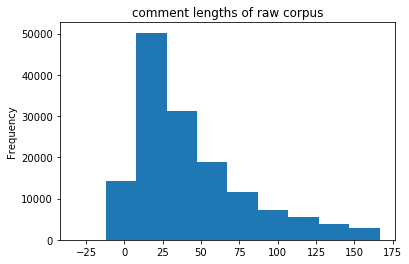

None


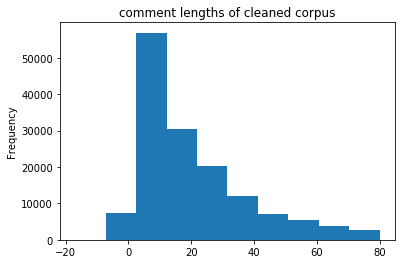

None
the lengths of the comments are distributed as follows:
 ********************************* 
 count                     159568
mean                     67.2722
std                      99.2308
min                            1
25%                           17
50%                           36
75%                           75
max                         1411
IQR                           58
outlier range     [-70.0, 162.0]
nr of outliers             14401
dtype: object 
 ******************************** 

the lengths of the cleaned comments are distributed as follows:
 ********************************* 
 count                    159568
mean                    31.5042
std                     48.4364
min                           0
25%                           8
50%                          17
75%                          35
max                        1250
IQR                          27
outlier range     [-32.5, 75.5]
nr of outliers            14576
dtype: object 
 *******************

In [26]:
print(histogram(corpus, prop, 'comment lengths of raw corpus'))
print(histogram(cleaned_corpus,prop, "comment lengths of cleaned corpus"))

print('the lengths of the comments are distributed as follows:\n','*'*33,'\n', describe(corpus,prop),'\n',"*"*32,'\n')
print('the lengths of the cleaned comments are distributed as follows:\n','*'*33,'\n', describe(cleaned_corpus,prop),'\n',"*"*32,'\n')

## Removing outliers from the dataset:

In [27]:
def remove_outliers(data, prop):
    outlier_range = describe(data, prop)['outlier range']
    corpus_without_outliers = [comment for comment in corpus if prop(comment)< outlier_range[1] and prop(comment)> outlier_range[0]]
    data_without_outliers = {comment: data[comment] for comment in corpus_without_outliers }
    return data_without_outliers

In [28]:
def cprop(comment):
    return len(cleaned_corpus_dict[comment])

## Describing the labels:

In [29]:
## the function below returns a bar plot of the probabilty for each category:

def plot_labels(data):

    def probability(data):
        
        labels = [data[comment] for comment in data]
        
        size = len(labels)
        frequency = []
        
        labels = np.array(labels)
        for index in range(num_categories):
            class_frequency = sum(labels[:,index])
            frequency.append(class_frequency)
        
        probability = [i/size for i in frequency]
        return probability
    
    
    probability = probability(data)
    
    #plot the figure:
    fig = plt.figure(figsize=(12, 4))
    
    #declare the title
    fig.suptitle("toxicity of comments")
    plt.autoscale(enable=False, axis='y')
    ind = np.arange(len(categories))
    plt.bar(ind, probability, width = 0.85, color='g')
    plt.xticks(ind, categories)
    plt.show()
    

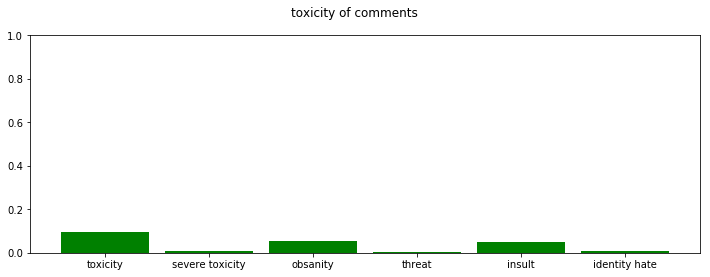

In [30]:
plot_labels(data)

In [31]:
print("about", 100*len([comment for comment in corpus if sum(data[comment])!= 0])/len(corpus), "percent of comments are nonzero")

about 10.1699588890003 percent of comments are nonzero


## Removing bias:

In [32]:
def reduce_bias(data, percentage):

    #obtain the nonzero comments:
    data_nonzero_labels = {comment: label for (comment, label) in data.items() if sum(label) != 0}
    
    #pick a random percentage of zero comments:
    size = round(percentage * len(data))
    list_of_comments = [comment for comment in data if comment not in data_nonzero_labels]
    sublist_of_comments = sample(list_of_comments, size)
    
    #turn the comments into a dataset
    smaller_data= {comment: data[comment] for comment in sublist_of_comments}

    # combine the above dataset together with the nonzero comments:
    smaller_data.update(data_nonzero_labels) 
    
    return smaller_data

# reducing the lengths of the comments:

## First method: pick the top TfIdf words:

In [33]:
# The function below computes the TfIdf score for each word in the corpus
# It returns score information as a couple 'TfIdf_info' which consists of 
# It first returns the sparse matrix 'scores'  whose (i,j)-th entry is the tfidf-score of word j within comment i 
# of the corpus
# In order to retrieve the score of a word (not just an abstract index), 
# it also returns 'vocab', an array whose j-th-entry is the word in column j of 'scores'

def TfIdf(corpus):
        
    # transform each comment into one single string in order to use TfIdf
    corpus_as_str = corpus_as_strings(corpus)
    
    #compute Tfidf scores
    tfidf=TfidfVectorizer()
    scores=tfidf.fit_transform(corpus_as_str)
        
    #TfIdf also assigns an index to each individual word. The following retrieves the word assigned to the index
    column_to_vocab=tfidf.get_feature_names()
        
    TfIdf_info = {'scores' : scores, 'column_to_vocab' : column_to_vocab}
        
    return  TfIdf_info
    
# next we construct a function that takes in the comment of the corpus and keeps only the the dimension-amount amount
# of words with top TfIdf scores.
#Since this function uses the TfIdf_info, we'll need to include the corpus to translate a row index to a comment:
    
def shrink_comment(comment, TfIdf_info, corpus, max_comment_length):
    
    scores = TfIdf_info['scores']
    column_to_vocab = TfIdf_info['column_to_vocab']
    
    # Obtain the row-index of the comment in the scores-matrix:
    i = corpus.index(comment)
    
    # Get the scores of each word in the comment of the corpus of given index 
    row = scores.getrow(i)
    
    # Keep the nonzero column-indices as an array
    indices = csr_matrix.nonzero(row)[1]
    
    # write down the Tfidf-score of each word-index
    entries = [scores[i,j] for j in indices]
    
    # sort those scores and keep only the top ones
    top_entries = np.argsort(entries)[-max_comment_length:]

    # get the corresponding column-index for each score
    top_word_indices = [indices[j] for j in top_entries]
    
    # get the corresponding word for each column index:
    shrunken_comment = [column_to_vocab[j] for j in top_word_indices]
    
    # make the schrunken comment into a tuple:
    shrunken_comment = tuple(shrunken_comment)
    
    return shrunken_comment

#finally, we apply the function to the whole of the corpus and return the results in the form of a dictionary:
#def reduce_comment_length(corpus, TfIdf_info, max_comment_length):
    
#    return {comment: shrink_comment(comment, TfIdf_info, corpus, max_comment_length) for comment in tqdm.tqdm(corpus)}

We illustrate how this procedure works on a specific comment:

In [34]:
TfIdf_info = TfIdf(cleaned_corpus)
scores = TfIdf_info['scores']
column_to_vocab = TfIdf_info['column_to_vocab']

In [35]:
index = np.random.choice((len(cleaned_corpus)),1)[0]
comment = corpus[index]
cleaned_comment = cleaned_corpus[index]

In [36]:
print('the comment:\n\n',' '.join(comment), '\n\n')


print('was cleaned into the comment:\n\n',' '.join(cleaned_comment), '\n\n')

# obtain the 22nd row in the scores matrix:
row = scores.getrow(index)

# obtain the nonzero indices in that row 
indices = csr_matrix.nonzero(row)[1]

#obtain the corresponding words in the vocab together with their TfIdf scores:
result = {column_to_vocab[j]: scores[index,j] for j in indices}

print('the TfIdf scores are:\n\n',result, '\n\n')

# shrink the comment to size 5: 
shrunken_comment = shrink_comment(cleaned_comment, TfIdf_info, cleaned_corpus, 5)

print('and was shrunk to the comment of size 5:\n\n', ' '.join(shrunken_comment))

the comment:

 Content from Future energy development should be merged here == Some content from the Hubbert peak article was moved to a new article Future energy development, this article seems like the more appropriate place to move that info if it's not redundant. Though perhaps alternative energy != renewable energy? 01:39, 12 Dec 2004 (UTC) == 


was cleaned into the comment:

 content future energy development merged content peak article moved new article future energy development article seems like appropriate place move info redundant though perhaps alternative energy renewable energy dec utc 


the TfIdf scores are:

 {'energy': 0.65591759580808273, 'future': 0.25178623150094803, 'development': 0.31012284536819362, 'redundant': 0.17005251234092106, 'seems': 0.10159186917538371, 'info': 0.12378879682432521, 'though': 0.10507659312830853, 'perhaps': 0.11406371680276339, 'moved': 0.13242854279473351, 'appropriate': 0.1223348986016457, 'renewable': 0.23986917533955468, 'utc': 0.09

There's a bug in the column_to_vocab method of the TfIdf vectorizer in which a tiny amount of words get reprinted incorrectly. for example 'i̇zmir' becomes 'zmir'..The following function fixes this:

In [37]:
def fix_bug(corpus, admissible_words):
    fixed_corpus = []
    for comment in corpus:
        comment = [word for word in comment if word in admissible_words]
        comment = tuple(comment)
        fixed_corpus.append(comment)
    return fixed_corpus

## Second method: Pick the first n words:

In [38]:
def slice_comment(comment, max_comment_length):
    return comment[:max_comment_length]


## Embedding the corpus and reducing the dimension:

In [39]:
# The following function embeds the vocabulary of the corpus and applies a principal component analysis.
# it returns embedded_vocab: a dictionary with
#   keys: words in the vocab
#   values: the embedded word with PCA applied to it
# Optionally, it also returns the explained variance of the PCA as well as the PCA object itself

def embed_vocab(vocab, embedding, dimension, pca = None):
    
    # embed the vocabulary in the form of a dictionary:
    embedded_vocab = {word : embedding[word] for word in vocab}
    
    # Build a PCA object:
    pca=PCA(n_components=dimension)
    
    #fit the object to the embedded vocab:
    pca.fit([embedded_vocab[word] for word in vocab])
    
    #return the variance of the PCA:
    variance = pca.explained_variance_ratio_
    
    #Apply the PCA to the embedded vocabulary:
    embedded_vocab = { word : tuple(pca.transform([embedding[word]])[0]) for word in vocab}
    if pca != None:
        return embedded_vocab, variance, pca 
    else:
        return embedded_vocab, variance


# Apply the above function to the each comment in the corpus:

def embed_comment(comment, embedded_vocab):
    
    embedded_comment = [embedded_vocab[word] for word in comment]
    
    embedded_comment = tuple(embedded_comment)
    
    return embedded_comment
    

## Reshaping the Matrices:

In [40]:
def reshape_comment(comment, m,n):

    l = len(comment)

    #Reformat the comment from a list to a a matrix of size lxn
    comment_array = np.asarray(comment)
    comment_matrix = comment_array.reshape(l,n)

    #Reshape the array of arrays into a single matrix:
    padding = np.zeros((m-l,n))
    reshaped_comment = np.concatenate((comment_matrix,padding),axis = 0)
        
    return reshaped_comment

def reshape_corpus(corpus,m,n):
    reshaped_corpus_dict = {comment: reshape_comment(comment,m,n) for comment in corpus}
    return reshaped_corpus_dict


## Prepping the data:

In [41]:
def prepare(data, embedding, prop, percentage, max_comment_length, dimension, method, verbose = None):

    # obtain the corpus from the data:
    corpus = [comment for comment in data.keys()]
    
    if verbose == True:
        #obtain the vocab of the corpus:
        vocab = get_vocab(corpus)
    
    #declare the admissible words:
    admissible_words = embedding.keys()
    
    if verbose == True:
        print('\n the corpus consists of', len(corpus),'comments and', len(vocab), 'words\n ')
        print("\n cleaning the corpus: \n")
        time.sleep(2)
    
    #obtain the cleaned corpus in the form of a disctionary since we will reuse it later:
    if verbose == True:
        cleaned_corpus_dict = {comment: clean_comment(comment, admissible_words) for comment in tqdm.tqdm(corpus)}
    else:
        cleaned_corpus_dict = {comment: clean_comment(comment, admissible_words) for comment in corpus}

    #obtain the cleaned vocab
    cleaned_vocab = get_vocab(cleaned_corpus_dict.keys())
    
    if verbose == True:
        print('\n the corpus was cleaned, the vocabulary now consists of', len(cleaned_vocab), 'words \n')
    
    #remove outliers from the data by considering the property associated to the cleaned comment:
    def cprop(comment):
        return prop(cleaned_corpus_dict[comment])
        
    data_without_outliers = remove_outliers(data, cprop)
    
    if verbose == True:
        print('\n',len(data)-len(data_without_outliers),'outliers were removed \n')
         
          
    #shrink the dataset to reduce bias towards nonzero comments:    
    smaller_data = reduce_bias(data_without_outliers, percentage)
    
    #get the smaller corpus:
    smaller_corpus = [comment for comment in smaller_data.keys()]
    
    #obtain the smaller cleaned corpus:
    smaller_cleaned_corpus = [cleaned_corpus_dict[comment] for comment in smaller_corpus]
    
    #obtain the smaller cleaned vocab
    smaller_cleaned_vocab = get_vocab(smaller_cleaned_corpus)
    
    if verbose == True:
        percentage = percentage *100
        print('\n the dataset was shrunk and only', percentage, 'percent of nonzero comments were kept \n')
        print('\n the dataset now consists of', len(smaller_cleaned_corpus), 'comments and',len(smaller_cleaned_vocab), 'words \n'  )
        print('\n reducing the comment length:\n')
        time.sleep(2)
    
    #next reduce the max size of each comment:
    if method == "TfIdf": 
        #obtain the TfIdf-info of the corpus:
        TfIdf_info = TfIdf(smaller_cleaned_corpus)
    
        # reduce the max comment length of the corpus
        if verbose == True:
            reduced_comment_corpus =  [shrink_comment(comment, TfIdf_info, smaller_cleaned_corpus, max_comment_length) for comment in tqdm.tqdm(smaller_cleaned_corpus)]
        else:
            reduced_comment_corpus =  [shrink_comment(comment, TfIdf_info, smaller_cleaned_corpus, max_comment_length) for comment in smaller_cleaned_corpus]
        
        #fix the mistranslation bug:
        reduced_comment_corpus = fix_bug(reduced_comment_corpus, admissible_words)
        if verbose == True:
            print('\n each comment was reduced to size at most', max_comment_length, 'by computing top TfIdf scores' '\n')

    elif method == 'slice':
        if verbose == True:
            reduced_comment_corpus = [slice_comment(comment, max_comment_length) for comment in tqdm.tqdm(smaller_cleaned_corpus)]
        else:
            reduced_comment_corpus = [slice_comment(comment, max_comment_length) for comment in smaller_cleaned_corpus]
        if verbose == True:        
            print('\n each comment was reduced to size at most', max_comment_length, 'by keeping only the first words' '\n')
            time.sleep(2)
    
    #obtain the vocab for the corpus of reduced comments:
    reduced_vocab = get_vocab(reduced_comment_corpus)
    
    #embed the vocab:
    embedded_vocab, variance, pca = embed_vocab(reduced_vocab, embedding, dimension)
    

    #embed the whole corpus:
    if verbose == True:
        embedded_corpus = [embed_comment(comment, embedded_vocab) for comment in tqdm.tqdm(reduced_comment_corpus)]
    else:
        embedded_corpus = [embed_comment(comment, embedded_vocab) for comment in reduced_comment_corpus]
 
    if verbose == True:          
        print('\n each comment was embedded into', '25-dimensional space \n and reduced to', dimension,'-dimensional space\n')
        print('\n the variance along each component is:', variance, '\n')
        time.sleep(2)     
    #reshape each embedded comment in the corpus:
    if verbose == True:
        reshaped_corpus =  [reshape_comment(comment, max_comment_length, dimension) for comment in tqdm.tqdm(embedded_corpus)]
        time.sleep(2)
    else:
        reshaped_corpus =  [reshape_comment(comment, max_comment_length, dimension) for comment in embedded_corpus]

          
          
    if verbose == True:      
        print('finally each comment was reshapen into a', max_comment_length, 'by', dimension, 'matrix' )
    
    embedding = dict(zip(smaller_corpus,reshaped_corpus))
    
    #reshape the corpus into a list of arrays
    return smaller_data, embedding

    
    
    

In [42]:
new_data, comment_embedding = prepare(data, embedding, prop, percentage, max_comment_length, dimension, 'TfIdf', True)


 the corpus consists of 159371 comments and 532227 words
 

 cleaning the corpus: 



100%|██████████| 159371/159371 [03:59<00:00, 665.31it/s]



 the corpus was cleaned, the vocabulary now consists of 532227 words 


 14549 outliers were removed 


 the dataset was shrunk and only 40.0 percent of nonzero comments were kept 


 the dataset now consists of 73218 comments and 50336 words 


 reducing the comment length:



100%|██████████| 73218/73218 [16:18<00:00, 74.80it/s]



 each comment was reduced to size at most 100 

100%|██████████| 73218/73218 [00:00<00:00, 177424.59it/s]


by computing top TfIdf scores


 each comment was embedded into 25-dimensional space 
 and reduced to 22 -dimensional space


 the variance along each component is: [ 0.14379875  0.0990197   0.06643492  0.05837384  0.05382225  0.04627029
  0.04222049  0.04050131  0.03936306  0.03703778  0.03532668  0.03425428
  0.03294008  0.03190535  0.03059773  0.02821238  0.02804978  0.02588921
  0.02512753  0.02287852  0.02173292  0.01826616] 



100%|██████████| 73218/73218 [00:06<00:00, 11469.87it/s]


finally each comment was reshapen into a 100 by 22 matrix


In [43]:
def preprocess(data, embedding):
    
    
    #obtain the embedded comment and associated label:
    embedded_data = [[embedding[comment], label] for (comment,label) in data.items()]
    
    features = [i[0] for i in embedded_data]
    labels = [i[1] for i in embedded_data]
    
    #split into traininf and testing features:
    training_features, testing_features, training_labels, testing_labels = train_test_split(features, labels,test_size=0.20, random_state=42)
    
    
    # turn into arrays for the purposes of Keras:
    training_features = np.asarray(training_features)
    testing_features = np.asarray(testing_features)
    training_labels = np.asarray(training_labels)
    testing_labels = np.asarray(testing_labels)
    
    features = {
        'testing' : testing_features,
        'training' : training_features,
    }
    
    labels = {
        'testing': testing_labels,
        'training': training_labels,    
        }

    return features, labels

In [44]:
features, labels = preprocess(new_data, comment_embedding)

# Preparing the Neural Net functionalities:

In [45]:
# the function below plots the learning curves of the network:

def learning_curves(model):
    #plot the learning curve for the accuracy
        #plot the accuracy on the training set
        plt.plot(model.history['f1'])
        #plot the accuracy on the testing set
        plt.plot(model.history['val_f1'])
        #describe the labels
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    # plot the learning curve for the loss
        #plot the loss on the training set
        plt.plot(model.history['loss'])
        #plot the loss on the testing set
        plt.plot(model.history['val_loss'])
        #describe the labels
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [46]:
## the function below creates a custom accuracy metric for our purposes:

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        
        """
        Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        
        labels = int_shape(y_pred)[1]
        true_positives = []
        total_positives = []
        
        fuzz = K.epsilon()
        
        for i in range(labels):
            # for each label, compute the number of true positives (correctly predicted positive values)
            true_positives.append(K.sum(K.round(K.clip(y_true[:, i] * y_pred[:, i], 0, 1))))
            
            #for each label, compute the number of positives
            total_positives.append(K.sum(K.round(K.clip(y_true[:, i], 0, 1))))
        
        #next, compute the percentage of true positives:
        true_positives = K.mean(tf.stack(true_positives), axis=-1)
        #compute the percentage of total positives
        total_positives = K.mean(tf.stack(total_positives), axis=-1) 
        
        
        # divide true positives by total positives (using a fuzz factor to avoid division by zero)
        recall = true_positives / (total_positives+fuzz)

        
        return recall

    def precision(y_true, y_pred):
        
        """
        Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        
        labels = int_shape(y_pred)[1]
        true_positives = []
        predicted_positives = []
        fuzz = K.epsilon()
        
        for i in range(labels):
            
            # for each label, compute the number of true positives
            true_positives.append(K.sum(K.round(K.clip(y_true[:, i] * y_pred[:, i], 0, 1))))
            
            #for each label compute the number of predicted positives
            predicted_positives.append(K.sum(K.round(K.clip(y_pred[:, i], 0, 1))))
        
        # compute the probability of true positives
        true_positives = K.mean(tf.stack(true_positives), axis=-1) 
        
        #compute the probability of predicted positives
        predicted_positives = K.mean(tf.stack(predicted_positives), axis=-1) 
        
        
        # divide both to obtain the precision (using a fuzz factor to avoif division by zero)
        precision = true_positives / (predicted_positives + fuzz)
        return precision
    
    
    #finally we'll compute the f1-score using the precision/recall formula
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1


In [47]:
## the function below creates a loss function better suited for our problem:

from sklearn.metrics import log_loss
from keras.backend import int_shape
import keras.backend as K
import tensorflow as tf
_EPSILON = K.epsilon()

def custom_loss(y_true, y_pred):
    losses = []
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    num_classes = int_shape(y_pred)[1]
    for i in range(num_classes):
        losses.append(-K.mean(
            y_true[:, i]*K.log(y_pred[:, i]) + (1.0-y_true[:, i])*K.log(1.0-y_pred[:, i]
        ), axis = -1))
    loss = tf.stack(losses)
    loss = K.mean(loss, axis=-1)
        
    return loss

In [48]:
## customize the callback for each epoch

import sklearn.metrics as sklm
from keras.callbacks import Callback

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.losses_dev = []


    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.losses_dev.append(logs.get('val_loss'))
        return

In [49]:
def run_model(model, epochs, batch_size):
    metrics = Metrics()
    model.compile(optimizer = 'adam', loss = custom_loss, metrics = [f1])
    fitted_model = model.fit(features['training'], labels['training'], validation_data=(features['testing'], labels['testing']), epochs = epochs, batch_size = batch_size, verbose =1)
    learning_curves(fitted_model)
    return fitted_model

# Building a basemodel:

We begin by building neural which takes in an input of size dimension. 
To this end, we simply embed each word according to the preprocessing steps and subsequently take the sum of each column vector in the embedding.

In [50]:
new_data, comment_embedding = prepare(data, embedding, prop, percentage, max_comment_length, dimension, 'TfIdf', False)
features, labels = preprocess(new_data, comment_embedding)

In [51]:
averaged_training_features = np.asarray([np.sum(feature, axis=0) for feature in features['training']])
averaged_testing_features = np.asarray([np.sum(feature, axis =0) for feature in features['testing']])

In [52]:
features['training'] = averaged_training_features
features['testing'] = averaged_testing_features

In [53]:
base_model = Sequential()
base_model.add(Dense(64, input_dim = dimension, activation = 'relu'))
base_model.add(Dense(32, input_dim = dimension))
base_model.add(Dense(6, activation = 'sigmoid'))

base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1472      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 3,750.0
Trainable params: 3,750
Non-trainable params: 0.0
_________________________________________________________________


Train on 58574 samples, validate on 14644 samples
Epoch 1/50
58574/58574 [==============================] - 7s - loss: 0.2134 - f1: 0.5222 - val_loss: 0.1471 - val_f1: 0.5936
Epoch 2/50
58574/58574 [==============================] - 4s - loss: 0.1454 - f1: 0.5841 - val_loss: 0.1349 - val_f1: 0.5851
Epoch 3/50
58574/58574 [==============================] - 4s - loss: 0.1382 - f1: 0.5891 - val_loss: 0.1313 - val_f1: 0.5850
Epoch 4/50
58574/58574 [==============================] - 4s - loss: 0.1344 - f1: 0.5923 - val_loss: 0.1332 - val_f1: 0.5614
Epoch 5/50
58574/58574 [==============================] - 4s - loss: 0.1340 - f1: 0.5893 - val_loss: 0.1313 - val_f1: 0.6164
Epoch 6/50
58574/58574 [==============================] - 4s - loss: 0.1323 - f1: 0.5952 - val_loss: 0.1305 - val_f1: 0.5602
Epoch 7/50
58574/58574 [==============================] - 4s - loss: 0.1309 - f1: 0.5993 - val_loss: 0.1350 - val_f1: 0.5658
Epoch 8/50
58574/58574 [==============================] - 4s - loss: 0.1303

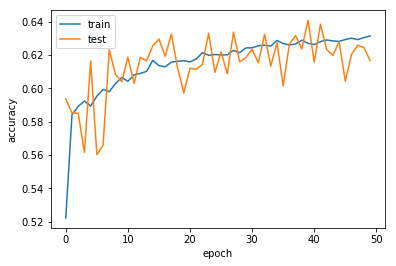

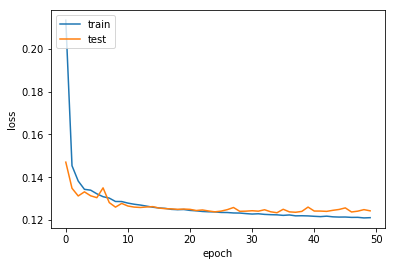

In [54]:
base_net = run_model(base_model, 50, 128)

## Building a Feedforward neural net:

we next build a neural net that takes in the whole matrix as input:

In [59]:
new_data, comment_embedding = prepare(data, embedding, prop, percentage, max_comment_length, dimension, 'TfIdf', False)
features, labels = preprocess(new_data, comment_embedding)

In [60]:
matrix_model = Sequential()
matrix_model.add(Dense(dimension*max_comment_length,input_shape = (max_comment_length, dimension), activation = 'relu'))
matrix_model.add(Dense(64, activation = 'relu'))
matrix_model.add(Flatten())
matrix_model.add(Dense(32 ))
matrix_model.add(Dense(6, activation ="sigmoid"))
matrix_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100, 2200)         50600     
_________________________________________________________________
dense_12 (Dense)             (None, 100, 64)           140864    
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                204832    
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 198       
Total params: 396,494.0
Trainable params: 396,494.0
Non-trainable params: 0.0
_________________________________________________________________


Train on 46988 samples, validate on 11748 samples
Epoch 1/50
46988/46988 [==============================] - 347s - loss: 0.1583 - f1: 0.6095 - val_loss: 0.1277 - val_f1: 0.7032
Epoch 2/50
46988/46988 [==============================] - 334s - loss: 0.1240 - f1: 0.7219 - val_loss: 0.1223 - val_f1: 0.7205
Epoch 3/50
46988/46988 [==============================] - 319s - loss: 0.1176 - f1: 0.7367 - val_loss: 0.1219 - val_f1: 0.7122
Epoch 4/50
46988/46988 [==============================] - 315s - loss: 0.1118 - f1: 0.7474 - val_loss: 0.1227 - val_f1: 0.7138
Epoch 5/50
46988/46988 [==============================] - 329s - loss: 0.1066 - f1: 0.7620 - val_loss: 0.1221 - val_f1: 0.7448
Epoch 6/50
46988/46988 [==============================] - 320s - loss: 0.1020 - f1: 0.7718 - val_loss: 0.1239 - val_f1: 0.7515
Epoch 7/50
46988/46988 [==============================] - 310s - loss: 0.0978 - f1: 0.7839 - val_loss: 0.1317 - val_f1: 0.7503
Epoch 8/50
46988/46988 [==============================] - 302

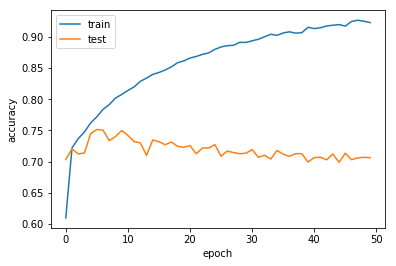

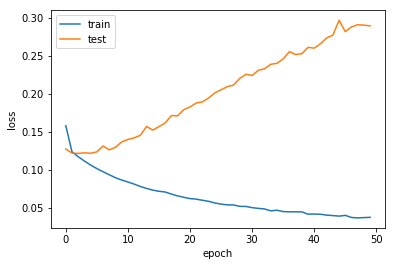

In [61]:
matrix_net = run_model(matrix_model, 50, 128)

## Building an LSTM neural net:

In [51]:
new_data, comment_embedding = prepare(data, embedding, prop, percentage, max_comment_length, dimension, 'slice', False)
features, labels = preprocess(new_data, comment_embedding)

In [55]:
RR_model = Sequential()
RR_model.add(LSTM(64,
               input_shape=(max_comment_length, dimension)))
RR_model.add(Dense(32, activation = 'relu'))
RR_model.add(Dense(6, activation='sigmoid'))
RR_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                22272     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 198       
Total params: 24,550.0
Trainable params: 24,550
Non-trainable params: 0.0
_________________________________________________________________


Train on 46988 samples, validate on 11748 samples
Epoch 1/50
46988/46988 [==============================] - 249s - loss: 0.2546 - f1: 0.1576 - val_loss: 0.2351 - val_f1: 0.3506
Epoch 2/50
46988/46988 [==============================] - 395s - loss: 0.2319 - f1: 0.3854 - val_loss: 0.2534 - val_f1: 0.2076
Epoch 3/50
46988/46988 [==============================] - 241s - loss: 0.2427 - f1: 0.2826 - val_loss: 0.2046 - val_f1: 0.5332
Epoch 4/50
46988/46988 [==============================] - 251s - loss: 0.1983 - f1: 0.5227 - val_loss: 0.1890 - val_f1: 0.5020
Epoch 5/50
46988/46988 [==============================] - 241s - loss: 0.1830 - f1: 0.5625 - val_loss: 0.1805 - val_f1: 0.5536
Epoch 6/50
46988/46988 [==============================] - 414s - loss: 0.1740 - f1: 0.5955 - val_loss: 0.1624 - val_f1: 0.6242
Epoch 7/50
46988/46988 [==============================] - 459s - loss: 0.1732 - f1: 0.5960 - val_loss: 0.2281 - val_f1: 0.2364
Epoch 8/50
46988/46988 [==============================] - 356

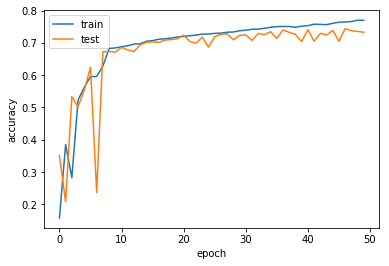

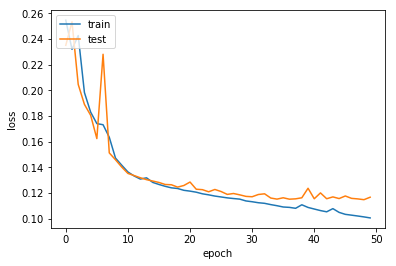

In [58]:
recurrent_net = run_model(RR_model, 50, 128)

## Test the model:

obtain the reduced vocab again:

In [75]:
cleaned_vocab = get_vocab(cleaned_corpus)

In [90]:
embedded_vocab, variance, pca = embed_vocab(cleaned_vocab, embedding, dimension, True)

In [103]:
def prep_new_comment(comment):
    
    comment_array = comment.split()
 
    cleaned_comment = clean_comment(comment_array)

    embedded_comment = [embedded_vocab[word] for word in cleaned_comment]

    reshaped_comment = reshape_comment(embedded_comment, max_comment_length, dimension)
    
    return reshaped_comment

In [124]:
def plot_predictions(probs, title):
    
    
    probabilities = [ round(i) for i in probs[0]]
    
    #plot the figure:
    fig = plt.figure(figsize=(12, 4))
    
    #declare the title
    fig.suptitle(title)
    plt.autoscale(enable=False, axis='y')
    ind = np.arange(len(probabilities))
    plt.bar(ind, probabilities, width = 0.85, color='g')
    plt.xticks(ind, categories)
    plt.show()
    
def predict(comment, model):
    prepped_comment = prep_new_comment(comment)
    
    # add brackets to make Keras tensor
    prepped_comment = np.array([prepped_comment])
    
    plot_predictions(model.predict(prepped_comment), comment)    

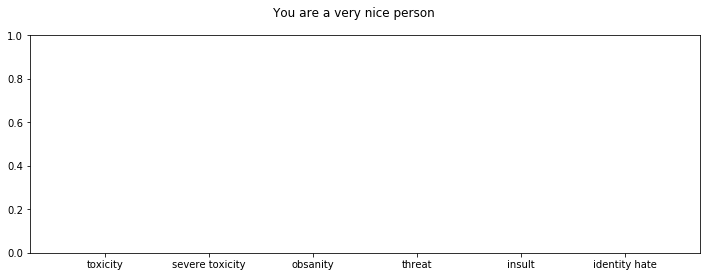

In [130]:
predict('You are a very nice person', matrix_model)

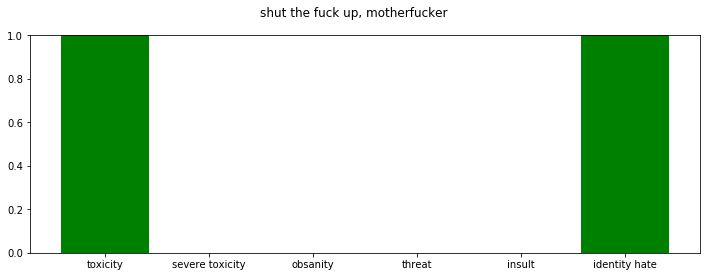

In [131]:
predict('shut the fuck up, motherfucker', matrix_model)